In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd ../gdrive/My Drive/Colab Notebooks/time_series

/gdrive/My Drive/Colab Notebooks/time_series


In [ ]:
!pip install gluonts
!pip install mxnet

In [ ]:
from gluonts.model.deepar import DeepAREstimator
#from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset

import mxnet as mx
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


Deep AR 

https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

https://ts.gluon.ai/api/gluonts/gluonts.model.deepar.html?highlight=deeparestimator#gluonts.model.deepar.DeepAREstimator



In [ ]:
# https://www.kaggle.com/competitions/recruit-restaurant-visitor-forecasting/data?select=air_visit_data.csv.zip

y = pd.read_csv('air_visit_data.csv')
y.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
y = y.pivot(index='visit_date', columns='air_store_id')['visitors']
y.head()

air_store_id,air_00a91d42b08b08d9,air_0164b9927d20bcc3,air_0241aa3964b7f861,air_0328696196e46f18,air_034a3d5b40d5b1b1,air_036d4f1ee7285390,air_0382c794b73b51ad,air_03963426c9312048,air_04341b588bde96cd,air_049f6d5b402a31b2,...,air_fd6aac1043520e83,air_fdc02ec4a3d21ea4,air_fdcfef8bd859f650,air_fe22ef5a9cbef123,air_fe58c074ec1445ea,air_fea5dc9594450608,air_fee8dcf4d619598e,air_fef9ccb3ba0da2f7,air_ffcc2d5087e1b476,air_fff68b929994bfbd
visit_date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,NaN,NaN,9.0,NaN,NaN,NaN,NaN,62.0,23.0,NaN,...,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,17.0,NaN,NaN,NaN,NaN,30.0,35.0,NaN,...,36.0,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
y = y.fillna(0)

In [ ]:
y = pd.DataFrame(y.sum(axis=1))

In [ ]:
y.head()

,0
visit_date,
2016-01-01,1033.0
2016-01-02,1764.0
2016-01-03,2368.0
2016-01-04,3326.0
2016-01-05,3927.0


In [ ]:
# This is how the model recognizes the date column (‘date’) and the dependent variable (‘y’). 
y = y.reset_index(drop=False)
y.columns = ['date', 'y']

In [ ]:
y.head()

,date,y
0,2016-01-01,1033.0
1,2016-01-02,1764.0
2,2016-01-03,2368.0
3,2016-01-04,3326.0
4,2016-01-05,3927.0


In [ ]:
y.shape

(478, 2)

In [ ]:
start = pd.Timestamp("01-01-2016", freq="D")
'''
Unlogically, it is necessary to specify the seasonality “H” for hourly..
..rather than “D” for daily to obtain a reasonably accurate forecast. 
This is likely due to an unresolved bug in gluonts at the time of writing.
'''

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': y.loc[:450,'y'], 'start': start}], freq='D')

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': y['y'], 'start': start}],freq='D')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.






1. The ctx is where you can specify whether you want to run on CPU or on GPU. Running on GPU is much faster, but you can do this only if you have a GPU available on your hardware.

2. The number of epochs is the number of times that you want all the data to be passed through the underlying deep neural network.

3. The learning rate is the step size for the optimizer of the neural network: a larger learning rate allows you to make larger steps, but it can miss the optimum, whereas a smaller learning rate may make the optimization slow or let you get stuck in a local optimum.

4. The prediction_length, which is the number of steps that you want to predict.





In [ ]:
np.random.seed(7)
mx.random.seed(7)


# need to create an estimator called the DeepAREstimator....which in turn uses a trainer.

estimator = DeepAREstimator(prediction_length=28,
                            context_length=100,
                            freq='D',
                            trainer=Trainer(#ctx="gpu", # remove if running on windows
                                            epochs=5,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=100)
                            )

predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:24<00:00,  4.13it/s, epoch=5/5, avg_epoch_loss=7.97]


In [ ]:
# Prediction

predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

0.5765020124838169


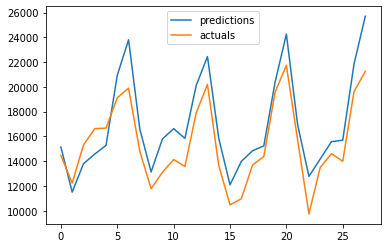

In [ ]:
# R2 score and prediction graph

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

print(r2_score( list(test_ds)[0]['target'][-28:], predictions))

plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-28:])
plt.legend(['predictions', 'actuals'])
plt.show()

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


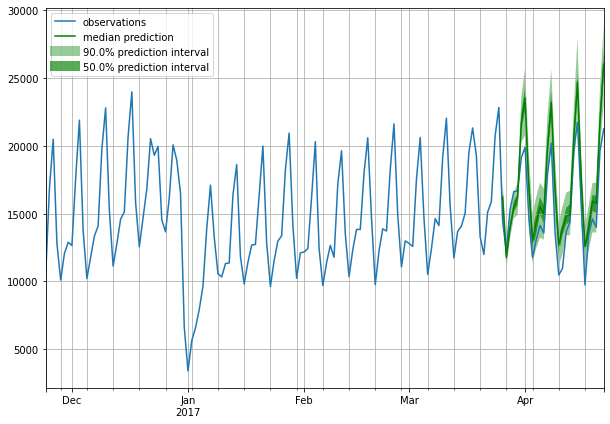

In [ ]:
# Probability forecast graph

from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
forecast_entry = forecasts[0]

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)
plt.show()

In [ ]:
# Preparing holidays and reservations data and adding them into the ListDataset

X_reservations = pd.read_csv('air_reserve.csv')
X_reservations['visit_date'] = pd.to_datetime(X_reservations['visit_datetime']).dt.date
X_reservations = pd.DataFrame(X_reservations.groupby('visit_date')['reserve_visitors'].sum())
X_reservations = X_reservations.reset_index(drop = False)

# Convert to datatime for merging correctly
y.date = pd.to_datetime(y.date)
X_reservations.visit_date = pd.to_datetime(X_reservations.visit_date)

# Merging and filling missing dates with 0
y = y.merge(X_reservations, left_on = 'date', right_on =  'visit_date', how = 'left').fillna(0)

# Preparing and merging holidays data
holidays = pd.read_csv('air_date_info.csv')
holidays.calendar_date = pd.to_datetime(holidays.calendar_date)
y = y.merge(holidays, left_on = 'date', right_on = 'calendar_date', how = 'left').fillna(0)

# Preparing the ListDatasets

train_ds = ListDataset([{
    'target': y.loc[:450,'y'],
    'start': start,
    'feat_dynamic_real': y.loc[:450,['reserve_visitors', 'holiday_flg']].values
    }], freq='H')

test_ds = ListDataset([{
    'target': y['y'], 
    'start': start, 
    'feat_dynamic_real': y.loc[:,['reserve_visitors', 'holiday_flg']].values
    }],freq='H')

In [ ]:
# Same code for fitting a different model: this model contains the two additional regressors

np.random.seed(7)
mx.random.seed(7)

# Build and fit model
estimator = DeepAREstimator(
    prediction_length=28,
    context_length=100,
    freq='D',
    trainer=Trainer(# ctx="gpu", # remove if running on windows
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

predictor = estimator.train(train_ds)

# Make Predictions
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

# Compute and print R2 score
print(r2_score( list(test_ds)[0]['target'][-28:], predictions))


/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:329: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future ver

0.8375022534066059


In [ ]:
# Tuning the hyperparameters

np.random.seed(7)
mx.random.seed(7)

results = []

for learning_rate in [1e-4, 1e-2]:
  for num_layers in [2, 5]:
    for num_cells in [30, 100]:

      estimator = DeepAREstimator(
          prediction_length=28,
          freq='D',
          trainer=Trainer(# ctx="gpu", # remove if on Windows
                          epochs=10,
                          learning_rate=learning_rate,
                          num_batches_per_epoch=100
                        ),
          num_layers = num_layers,
          num_cells = num_cells,
      )

      predictor = estimator.train(train_ds)

      predictions = predictor.predict(test_ds)

      r2 = r2_score(list(predictions)[0].quantile(0.5), list(test_ds)[0]['target'][-28:])
      result = [learning_rate, num_layers, num_cells, r2]
      print(result)
      results.append(result)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed 

[0.0001, 2, 30, 0.6217077276812266]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:18<00:00,  5.35it/s, epoch=10/10, avg_epoch_loss=8.27]
/usr/local/lib/python3

[0.0001, 2, 100, 0.6659091908244388]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:17<00:00,  5.80it/s, epoch=10/10, avg_epoch_loss=8.34]
/usr/local/lib/python3

[0.0001, 5, 30, 0.6383761136251084]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:46<00:00,  2.15it/s, epoch=10/10, avg_epoch_loss=8.29]
/usr/local/lib/python3

[0.0001, 5, 100, 0.8390589062250071]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:08<00:00, 11.98it/s, epoch=10/10, avg_epoch_loss=7.64]
/usr/local/lib/python3

[0.01, 2, 30, 0.6667034654766048]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:18<00:00,  5.32it/s, epoch=10/10, avg_epoch_loss=7.56]
/usr/local/lib/python3

[0.01, 2, 100, 0.7713711229625355]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:18<00:00,  5.29it/s, epoch=10/10, avg_epoch_loss=7.75]
/usr/local/lib/python3

[0.01, 5, 30, 0.3129839884728135]


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
100%|██████████| 100/100 [00:47<00:00,  2.13it/s, epoch=10/10, avg_epoch_loss=7.88]


[0.01, 5, 100, 0.8731326841489226]
